In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [27]:
DATA_PATH = 'data/gestures.csv'
MODEL_PATH = 'models/model1.pth'

In [28]:
data = pd.read_csv(DATA_PATH, header = None)
print(f'Full data shape:{data.shape}')

Full data shape:(432, 14)


In [29]:
# Train and test sets
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0, stratify = data[0])

print(f'samples training data:{train_data.shape[0]} | samples test data:{test_data.shape[0]}')

samples training data:345 | samples test data:87


In [30]:
class LandmarkDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        target = torch.tensor(self.df.values[:, 0]).type(torch.LongTensor)
        features = torch.tensor(self.df.values[:, 1:], dtype = torch.float)
        return features[index], target[index]
    
    
train_set = LandmarkDataset(train_data)
test_set = LandmarkDataset(test_data)

In [31]:
b_size = 16
trainloader = DataLoader(train_set, batch_size = b_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = b_size, shuffle = False)

In [32]:
# checking data from DataLoader is as expected
x, y = next(iter(trainloader))
x.shape, y.shape

(torch.Size([16, 13]), torch.Size([16]))

Epoch 1/120
Train loss: 2.5027
Test accuracy: 52.23%
Epoch 2/120
Train loss: 2.3407
Test accuracy: 79.17%
Epoch 3/120
Train loss: 2.2117
Test accuracy: 81.25%
Epoch 4/120
Train loss: 2.1641
Test accuracy: 83.33%
Epoch 5/120
Train loss: 2.0818
Test accuracy: 83.33%
Epoch 6/120
Train loss: 2.0130
Test accuracy: 89.58%
Epoch 7/120
Train loss: 1.9604
Test accuracy: 90.62%
Epoch 8/120
Train loss: 1.9432
Test accuracy: 93.75%
Epoch 9/120
Train loss: 1.9614
Test accuracy: 94.79%
Epoch 10/120
Train loss: 1.9163
Test accuracy: 93.75%
Epoch 11/120
Train loss: 1.8908
Test accuracy: 93.75%
Epoch 12/120
Train loss: 1.8547
Test accuracy: 93.75%
Epoch 13/120
Train loss: 1.8946
Test accuracy: 96.88%
Epoch 14/120
Train loss: 1.8643
Test accuracy: 91.67%
Epoch 15/120
Train loss: 1.8406
Test accuracy: 97.92%
Epoch 16/120
Train loss: 1.8434
Test accuracy: 93.75%
Epoch 17/120
Train loss: 1.8816
Test accuracy: 94.79%
Epoch 18/120
Train loss: 1.8163
Test accuracy: 97.92%
Epoch 19/120
Train loss: 1.8286
Test 

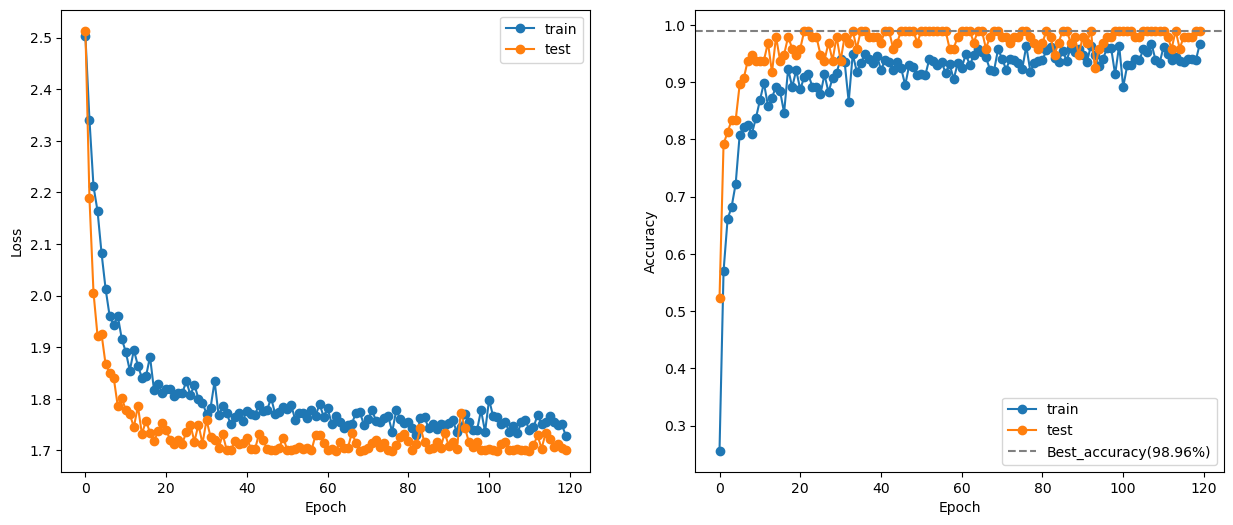

In [33]:
# ...existing imports and data loading code...

class EnhancedNN(nn.Module):
    def __init__(self, n_features, n_classes, hidden_sizes=[64, 128, 256, 128, 64]):
        super(EnhancedNN, self).__init__()
        self.bn1 = nn.BatchNorm1d(n_features)
        self.fc1 = nn.Linear(n_features, hidden_sizes[0])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn4 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.bn5 = nn.BatchNorm1d(hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.bn6 = nn.BatchNorm1d(hidden_sizes[4])
        self.output = nn.Linear(hidden_sizes[4], n_classes)
        
        self.dropout = nn.Dropout(0.3)
        self.gelu = nn.GELU()
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.elu = nn.ELU()
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.gelu(self.fc1(x))
        x = self.dropout(self.bn2(x))
        
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(self.bn3(x))
        
        x = self.elu(self.fc3(x))
        x = self.dropout(self.bn4(x))
        
        x = self.gelu(self.fc4(x))
        x = self.dropout(self.bn5(x))
        
        x = self.leaky_relu(self.fc5(x))
        x = self.dropout(self.bn6(x))
        
        return F.softmax(self.output(x), dim=1)

# Model initialization
n_features = data.shape[1] - 1
n_classes = len(data[0].unique())
model = EnhancedNN(n_features, n_classes)

# Training parameters
model.to(device)
learning_rate = 0.001
epochs = 120

optimizer = optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.75
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0
    
    # training
    for x_train_batch, y_train_batch in trainloader:
        x_train_batch = x_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)

        optimizer.zero_grad()

        # forward pass
        scores = model(x_train_batch)
        train_preds = torch.argmax(scores.detach(), dim=1)

        # loss
        train_loss = criterion(scores, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass
        
        train_loss.backward()
        
        # update paramaters
        
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            x_test_batch = x_test_batch.to(device)
            y_test_batch = y_test_batch.to(device)
            # logits
            test_scores = model(
                x_test_batch)

            # predictions
            test_preds = torch.argmax(test_scores, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()

            # loss
            test_loss = criterion(test_scores, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_loss / len(testloader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.to('cpu').state_dict(), MODEL_PATH)
            
            # bring back to gpu
            model.to(device) 

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()